In [2]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time
import cv2

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from data_manager import *
from metadata import *

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.transform import rotate
from multiprocess import Pool

import pandas

Setting environment for Gordon


No vtk


In [11]:
from cell_utilities import *

In [14]:
stack = 'MD594'

In [15]:
sections_to_filenames = metadata_cache['sections_to_filenames'][stack]
first_bs_section, last_bs_section = metadata_cache['section_limits'][stack]

In [16]:
DETECTED_CELLS_DIR = os.path.join(DETECTED_CELLS_ROOTDIR, stack)

# Load processed cells

In [17]:
cells_aligned_padded = load_cell_data(what='cells_aligned_padded', stack=stack, sec=200)
cells_aligned_padded_h = load_cell_data(what='cells_aligned_padded_h', stack=stack, sec=200)
cells_aligned_padded_v = load_cell_data(what='cells_aligned_padded_v', stack=stack, sec=200)
cells_aligned_padded_d = load_cell_data(what='cells_aligned_padded_d', stack=stack, sec=200)

In [18]:
n_cells = len(cells_aligned_padded)
print n_cells, 'cells'

# cells_aligned_padded_flattened = np.reshape(cells_aligned_padded, (n_cells, -1))
# cells_aligned_padded.shape

cell_sizes = np.reshape(cells_aligned_padded, (n_cells, -1)).sum(axis=1)

91511 cells


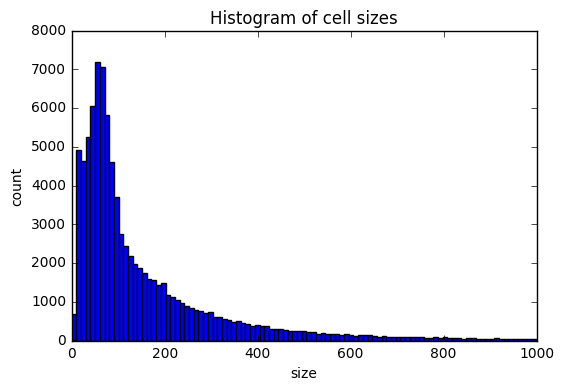

In [19]:
plt.hist(cell_sizes, bins=np.linspace(0, 1000, 100));
plt.title('Histogram of cell sizes');
plt.xlabel('size');
plt.ylabel('count');
plt.show();

In [20]:
# Select only the top 30% large cells and do spectral embedding only for them.

cutoff_percentage_small_medium = .3
cutoff_percentage_medium_large = .7
c1 = int(cutoff_percentage_small_medium*n_cells)
c2 = int(cutoff_percentage_medium_large*n_cells)
indices_sorted_by_size = np.argsort(cell_sizes)
small_cell_indices = indices_sorted_by_size[:c1]
medium_cell_indices = indices_sorted_by_size[c1:c2]
large_cell_indices = indices_sorted_by_size[c2:]

n_small_cells = len(small_cell_indices)
n_medium_cells = len(medium_cell_indices)
n_large_cells = len(large_cell_indices)

print n_small_cells, n_medium_cells, n_large_cells

27453 36604 27454


In [21]:
selected_cell_indices = np.sort(large_cell_indices)
# dataset_name = 'largest30p'
dataset_name = 'largest30p_sizeNormalized'

n_selected_cells = len(selected_cell_indices)

In [22]:
CELL_EMBEDDING_DIR = create_if_not_exists(os.path.join(CELL_EMBEDDING_ROOTDIR, dataset_name))

In [20]:
# cells_aligned_padded = bp.unpack_ndarray_file(output_dir + '/cells_aligned_padded.bp')
selected_cells_aligned_padded = cells_aligned_padded[selected_cell_indices].copy()
del cells_aligned_padded

In [22]:
# cells_h_aligned_padded = bp.unpack_ndarray_file(output_dir + '/cells_h_aligned_padded.bp')
selected_cells_aligned_padded_h = cells_aligned_padded_h[selected_cell_indices].copy()
del cells_aligned_padded_h

In [23]:
# cells_v_aligned_padded = bp.unpack_ndarray_file(output_dir + '/cells_v_aligned_padded.bp')
selected_cells_aligned_padded_v = cells_aligned_padded_v[selected_cell_indices].copy()
del cells_aligned_padded_v

In [24]:
# cells_d_aligned_padded = bp.unpack_ndarray_file(output_dir + '/cells_d_aligned_padded.bp')
selected_cells_aligned_padded_d = cells_aligned_padded_d[selected_cell_indices].copy()
del cells_aligned_padded_d

In [56]:
selected_cell_sizes = cell_sizes[selected_cell_indices]

In [51]:
bp.pack_ndarray_file(selected_cells_aligned_padded, os.path.join(CELL_EMBEDDING_DIR, '%(dataset_name)s_cellsAlignedPadded.bp' % dict(dataset_name=dataset_name)))

In [ ]:
# nonsmall_cell_masks_normalized_flattened = cell_masks_normalized_flattened[nonsmall_cells_indices].copy()
# nonsmall_cell_masks_normalized_size = cell_masks_normalized_size[nonsmall_cells_indices].copy()
# print nonsmall_cell_masks_normalized_flattened.shape

# Rescale all cells to the same size (optional)

In [61]:
mean_size = int(selected_cell_sizes.mean())
median_size = int(np.median(selected_cell_sizes))
print 'mean', mean_size, 'median', median_size

mean 382 median 290


In [62]:
def rescale_cell(i, mean_size):
    c = selected_cells_aligned_padded[i]
    s = selected_cell_sizes[i]
    rescaled = rescale(c, np.sqrt(float(mean_size)/s), cval=0) > .5
    xmin, xmax, ymin, ymax = bbox_2d(rescaled)
    rescaled_centered = rescaled[ymin:ymax+1, xmin:xmax+1].copy()
    return rescaled_centered

In [64]:
t = time.time()

pool = Pool(15)
selected_cells_aligned_rescaled = pool.map(lambda i: rescale_cell(i, mean_size), range(n_selected_cells))
pool.terminate()
pool.join()

sys.stderr.write('Scale to same size: %f s.\n' % (time.time()-t)) # 24s / 60k cells

Scale to same size: 6.936948 s.


In [65]:
common_shape = (57,62)

In [77]:
selected_cells_aligned_rescaled_padded = np.asarray(pad_patches_to_same_size(selected_cells_aligned_rescaled, 
                                          pad_value=0, keep_center=True, common_shape=common_shape))

In [78]:
selected_cells_aligned_rescaled_padded_h = np.asarray([m[:, ::-1] for m in selected_cells_aligned_rescaled_padded])
selected_cells_aligned_rescaled_padded_v = np.asarray([m[::-1, :] for m in selected_cells_aligned_rescaled_padded])
selected_cells_aligned_rescaled_padded_d = np.asarray([m[::-1, ::-1] for m in selected_cells_aligned_rescaled_padded])

In [122]:
# selected_cells_aligned_rescaled_padded_flattened = np.reshape(selected_cells_aligned_rescaled_padded, (n_selected_cells, -1))
selected_cell_rescaled_sizes = selected_cells_aligned_rescaled_padded_flattened.sum(axis=1)

In [153]:
bp.pack_ndarray_file(selected_cells_aligned_rescaled_padded, 
                     os.path.join(CELL_EMBEDDING_DIR, '%(dataset_name)s_cellsAlignedPadded.bp' % 
                                  {'dataset_name': dataset_name}))

bp.pack_ndarray_file(selected_cells_aligned_rescaled_padded_h, 
                     os.path.join(CELL_EMBEDDING_DIR, '%(dataset_name)s_cellsAlignedPadded_h.bp' % 
                                  {'dataset_name': dataset_name}))

bp.pack_ndarray_file(selected_cells_aligned_rescaled_padded_v, 
                     os.path.join(CELL_EMBEDDING_DIR, '%(dataset_name)s_cellsAlignedPadded_v.bp' % 
                                  {'dataset_name': dataset_name}))

bp.pack_ndarray_file(selected_cells_aligned_rescaled_padded_d, 
                     os.path.join(CELL_EMBEDDING_DIR, '%(dataset_name)s_cellsAlignedPadded_d.bp' % 
                                  {'dataset_name': dataset_name}))

bp.pack_ndarray_file(np.array(selected_cell_rescaled_sizes), 
                     os.path.join(CELL_EMBEDDING_DIR, '%(dataset_name)s_rescaledSizes.bp' % 
                                  {'dataset_name': dataset_name}))

# bp.pack_ndarray_file(selected_cells_indices, 
#                      os.path.join(CELL_EMBEDDING_DIR, '%(dataset_name)s_indices.bp' % \
#                                   {'dataset_name': dataset_name, 'cutoff': cutoff_percentage_small_medium*100}))

In [21]:
# bp.pack_ndarray_file(np.array(selected_cells_aligned_padded), output_dir + '/%(dataset_name)s_aligned_padded_cutoff%(cutoff)d.bp' % 
#                      {'dataset_name': dataset_name, 'cutoff': cutoff_percentage_medium_large*100})

# bp.pack_ndarray_file(np.array(selected_cells_h_aligned_padded), output_dir + '/%(dataset_name)s_h_aligned_padded_cutoff%(cutoff)d.bp' % 
#                      {'dataset_name': dataset_name, 'cutoff': cutoff_percentage_medium_large*100})

# bp.pack_ndarray_file(np.array(selected_cells_v_aligned_padded), output_dir + '/%(dataset_name)s_v_aligned_padded_cutoff%(cutoff)d.bp' % 
#                      {'dataset_name': dataset_name, 'cutoff': cutoff_percentage_medium_large*100})

# bp.pack_ndarray_file(np.array(selected_cells_d_aligned_padded), output_dir + '/%(dataset_name)s_d_aligned_padded_cutoff%(cutoff)d.bp' % 
#                      {'dataset_name': dataset_name, 'cutoff': cutoff_percentage_medium_large*100})

bp.pack_ndarray_file(np.array(selected_cell_sizes), output_dir + '/%(dataset_name)s_sizes.bp' % 
                     {'dataset_name': dataset_name})

bp.pack_ndarray_file(selected_cell_indices, output_dir + '/%(dataset_name)s_indices.bp' % 
                     {'dataset_name': dataset_name})

# KMeans++

In [ ]:
# set_selected_cell_arrays(selected_cells_aligned_padded.reshape((n_selected_cells, -1)), 
#                          selected_cells_aligned_padded_h.reshape((n_selected_cells, -1)),
#                         selected_cells_aligned_padded_v.reshape((n_selected_cells, -1)),
#                         selected_cells_aligned_padded_d.reshape((n_selected_cells, -1)),
#                         selected_cell_sizes)

In [143]:
set_selected_cell_arrays(selected_cells_aligned_rescaled_padded.reshape((n_selected_cells, -1)), 
                         selected_cells_aligned_rescaled_padded_h.reshape((n_selected_cells, -1)),
                        selected_cells_aligned_rescaled_padded_v.reshape((n_selected_cells, -1)),
                        selected_cells_aligned_rescaled_padded_d.reshape((n_selected_cells, -1)),
                        selected_cell_rescaled_sizes)

In [144]:
def kmeans_plusplus(n_class):
    """
    compute_jaccard_i_vs_all() uses module-wide variables set by set_selected_cell_arrays().
    """
    
    seeds = np.empty((n_class, ), np.int)

    distances_to_closest_seed = np.empty((n_selected_cells, ))
    indices_of_closest_seed = np.empty((n_selected_cells, ), np.int)

    t1 = time.time()

    bar = show_progress_bar(0, n_class)

    for it in range(n_class):

        bar.value = it

        if it == 0:
            seed = np.random.randint(n_selected_cells)
        else:
            seed = np.random.choice(range(n_selected_cells), 1, p=d2_weights)[0]

        seeds[it] = int(seed)

    #     t = time.time()
        distances = 1. - compute_jaccard_i_vs_all(seed)
    #     distances = 1. - compute_jaccard_with_i_parallel(seed)
    #     print time.time() - t
        # sequential: 0.05-0.5s / 20k cells
        # parallel: 0.35s, even slower than sequential


        if it == 0:
            distances_to_closest_seed = distances
            indices_of_closest_seed[:] = 0
        else:    
            needs_update = distances < distances_to_closest_seed
            distances_to_closest_seed[needs_update] = distances[needs_update]
            indices_of_closest_seed[needs_update] = it
            
        d2s = distances_to_closest_seed**2
        d2_weights = d2s / d2s.sum()

    sys.stderr.write('Kmeans++: %.2f seconds.\n' % (time.time() - t1)) # 164s / 1000 centers
    
    return seeds, indices_of_closest_seed

In [145]:
seeds, indices_of_closest_seed = kmeans_plusplus(n_class=100)

Kmeans++: 25.35 seconds.


In [146]:
bp.pack_ndarray_file(seeds, os.path.join(CELL_EMBEDDING_DIR, '%(dataset_name)s_kmeansppCenters.bp' % {'dataset_name': dataset_name}))

bp.pack_ndarray_file(indices_of_closest_seed, os.path.join(CELL_EMBEDDING_DIR, '%(dataset_name)s_closestKmeansppCenters.bp' % \
                     {'dataset_name': dataset_name}))

# bp.pack_ndarray_file(memberCount, output_dir + '/%(dataset_name)s_indices_cutoff%(cutoff)d_kmeansppCentersMemberCount.bp' % \
#                     {'dataset_name': dataset_name, 'cutoff': cutoff_percentage_medium_large*100})

# Load Kmeans++ results

In [42]:
seeds = bp.unpack_ndarray_file(os.path.join(CELL_EMBEDDING_ROOTDIR, '%(dataset_name)s_kmeansppCenters.bp' % \
                               {'dataset_name': dataset_name}))

indices_of_closest_seed = bp.unpack_ndarray_file(os.path.join(CELL_EMBEDDING_ROOTDIR, '%(dataset_name)s_closestKmeansppCenters.bp' % \
                                                 {'dataset_name': dataset_name}))

print len(seeds), 'kmeans++ centers'

100 kmeans++ centers


In [147]:
memberCount = np.bincount(indices_of_closest_seed, minlength=len(seeds))
seedIndices_sorted_by_memberCount = np.argsort(memberCount)[::-1]
memberCount_sorted = memberCount[seedIndices_sorted_by_memberCount]
seeds_ranked_by_memberCount = seeds[seedIndices_sorted_by_memberCount]

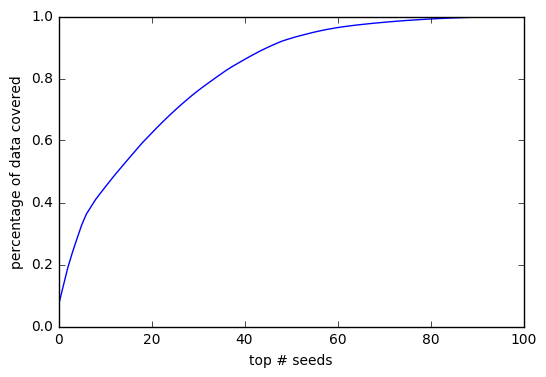

In [148]:
plt.plot(np.cumsum(memberCount_sorted) / float(n_selected_cells));
plt.xlabel('top # seeds');
plt.ylabel('percentage of data covered');

In [149]:
def compute_embedding(sample_indices):
    """
    compute_jaccard_i_vs_all() uses module-wide variables set by set_selected_cell_arrays().
    """
    
    n_samples = len(sample_indices)
    
    t = time.time()

    affinities_with_samples = compute_jaccard_list_vs_all(sample_indices)

    sys.stderr.write('Compute pairwise affinities (with samples): %f s.\n' % (time.time()-t)) # 10 s / 200
    
    nonsample_indices = np.setdiff1d(range(affinities_with_samples.shape[1]), sample_indices)
    permutation = np.r_[sample_indices, nonsample_indices]

    ########################

    t = time.time()

    from scipy.linalg import sqrtm

    A = affinities_with_samples[:, sample_indices].copy()
    B = affinities_with_samples[:, nonsample_indices].copy()

    d1 = np.sum(np.c_[A, B], axis=1)
    Ai = np.linalg.inv(A)
    d2 = np.sum(B, axis=0) + np.dot(B.T, np.dot(Ai, np.sum(B, axis=1)))
    dhat_si = np.sqrt(1./np.r_[d1, d2])
    A = A*np.outer(dhat_si[:n_samples], dhat_si[:n_samples])
    B = B*np.outer(dhat_si[:n_samples], dhat_si[n_samples:])

    if any(np.linalg.eigvals(A) < 0):
        # A is indefinite
        print 'A is indefinite'

        U, L, UT = np.linalg.svd(A)

        Ubar = np.c_[U.T, np.dot(np.dot(np.linalg.inv(np.diag(L)), U.T), B)]
        Z = np.dot(Ubar.T, np.diag(np.sqrt(L)))
        F, S, FT = np.linalg.svd(np.dot(Z.T, Z))
        V = np.dot(np.dot(Z, F), np.linalg.inv(np.diag(np.sqrt(S))))

    else:
        # A is positive definite
        print 'A is positive definite'
        
        Asi = sqrtm(Ai)

        M = np.dot(B.T, Asi)
        S = A + np.dot(M.T, M)

        U, L, T = np.linalg.svd(S)

        V = np.dot(np.vstack([A, B.T]), np.dot(Asi, np.dot(U, np.linalg.inv(np.diag(np.sqrt(L))))))

    sys.stderr.write('Nystroem: %f s.\n' % (time.time()-t))


    ##########################

    E_allEig = V[:,1:]/V[:,0][:,None]

    E_allEig_original_order = np.zeros_like(E_allEig)
    E_allEig_original_order[permutation] = E_allEig
    
    return E_allEig_original_order

In [150]:
# our data, Nystroem extension
# https://people.eecs.berkeley.edu/~malik/papers/FBCM-nystrom.pdf


# for n_seeds in [100, 200, 1000]:
n_nystrom_samples = 100
nystrom_sample_indices = seeds_ranked_by_memberCount[:n_nystrom_samples].copy() # Use top n_nystrom_samples most populated kmeans++ centers
embeddings = compute_embedding(nystrom_sample_indices)

embeddings_normalized = (embeddings - embeddings.mean(axis=0)) / embeddings.std(axis=0)

#     bp.pack_ndarray_file(E_allEig_original_order, 
#                          output_dir +  '/embeddingAllEigen_%(dataset_name)s_nystromSample%(n_seeds)d.bp' % \
#                          {'dataset_name': dataset_name, 'n_seeds': n_seeds})

# print E_allEig_original_order.mean(axis=0)
# print E_allEig_original_order.std(axis=0)

# E_allEig_original_order_normalized = (E_allEig_original_order-E_allEig_original_order.mean(axis=0))/E_allEig_original_order.std(axis=0)

#     bp.pack_ndarray_file(E_allEig_original_order_normalized, 
#                          output_dir + '/embeddingAllEigenNormalized_%(dataset_name)s_nystromSample%(n_seeds)d.bp' % \
#                          {'dataset_name': dataset_name, 'n_seeds': n_seeds})

Compute pairwise affinities (with samples): 2.521326 s.
Nystroem: 0.184314 s.


A is positive definite


In [151]:
bp.pack_ndarray_file(embeddings, os.path.join(CELL_EMBEDDING_DIR, 'embeddings_%(dataset_name)s_nystromSample%(n_samples)d.bp' % \
                     {'dataset_name': dataset_name, 'n_samples': n_nystrom_samples}))
bp.pack_ndarray_file(embeddings_normalized, os.path.join(CELL_EMBEDDING_DIR, 'embeddings_normalized_%(dataset_name)s_nystromSample%(n_samples)d.bp' % \
                     {'dataset_name': dataset_name, 'n_samples': n_nystrom_samples}))

In [152]:
print embeddings.shape

(26350, 99)
